In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


**Gerekli Kütüphaneler**
NumPy: sayısal diziler ve matris işlemleri, 
Pandas: tablo verisi analizi, 
OS: dosya ve klasör yönetimi, 
Matplotlib: ise veri görselleştirme için kullanılır.

In [13]:
# Gerekli kütüphaneleri içe aktaralım
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


**Derin öğrenme için gerekli kütüphaneler:**

**ImageDataGenerator**: Görüntüleri yüklemek,boyutlandırmak, veri çoğaltmak için kullanmalıyız.
**Sequential:** Modelimizin mimarisini kurmak için katmanları oluşturmak için kullanmalıyız.
**Adam,EarlyStopping,ModelCheckPoint:** Modeli daha verimli ve başarılı bir şekilde eğitmek için kullanılır.

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
import cv2

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten ,Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**1. Veri Setini Yükleme ve Keşfetme**

fer2013.csv dosyasını okuyacak ve ilk birkaç satırını gösterecektir. Ayrıca, **emotion** sütunundaki her duygu sınıfından kaçar tane veri olduğunu da görebiliriz.

In [16]:
data_dir= '/kaggle/input/fer2013/' #veri seti ana dizini

csv_path=os.path.join(data_dir,'fer2013.csv') #veri setindeki csv dosyasının yolu

df=pd.read_csv(csv_path) #csv dosya oku

print(df.head()) #veri setini incele

print(df['emotion'].value_counts())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


In [17]:
# Duygu sınıfları için bir sözlük tanımlayalım
EMOTION_MAP = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [18]:
#görüntü boyutumuz 48*48 olduğundan;

IMG_HEIGHT = 48
IMG_WIDTH = 48

#piksel verisini ayıklamak lazım

pixels=df['pixels'].tolist() #pixel sütunun metinlerini ayrı elemanlı listeye çevirir.

faces=[]  #faces boş liste
for pixel_sequence in pixels: #listedeki her bir metin üzerinde döngü başlatırız.
    face=[int(p) for p in pixel_sequence.split(' ')]  #her metini splitle boşluklara ayırıp int ile tam sayıya dönüştürürüz.
    face=np.asarray(face).reshape(IMG_WIDTH,IMG_HEIGHT) #tek boyutlu piksel listesini 48x48 boyutunda 2 boyutlu matrise array ile dönüştürür.
    faces.append(face.astype('float32'))  #dönüstürülen matris faces listesine eklenir.
    

Ek boyut ekleme ve normalizasyon

In [19]:
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 255.0  # Normalizasyon

emotions = df['emotion'].values

In [20]:
# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(faces, emotions, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
# Etiketleri one-hot encoding yapma
y_train_categorical = to_categorical(y_train, 7)
y_val_categorical = to_categorical(y_val, 7)
y_test_categorical = to_categorical(y_test, 7)


In [26]:
# Veri çoğaltma için ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
datagen.fit(X_train)

print(f"Eğitim Verisi Şekli: {X_train.shape}")
print(f"Doğrulama Verisi Şekli: {X_val.shape}")
print(f"Test Verisi Şekli: {X_test.shape}")

Eğitim Verisi Şekli: (25120, 48, 48, 1)
Doğrulama Verisi Şekli: (5383, 48, 48, 1)
Test Verisi Şekli: (5384, 48, 48, 1)


Eğitim verisi şekli: (25120, 48, 48, 1)
Test verisi şekli: (5384, 48, 48, 1)
Gerçek sınıf sayısı: 7


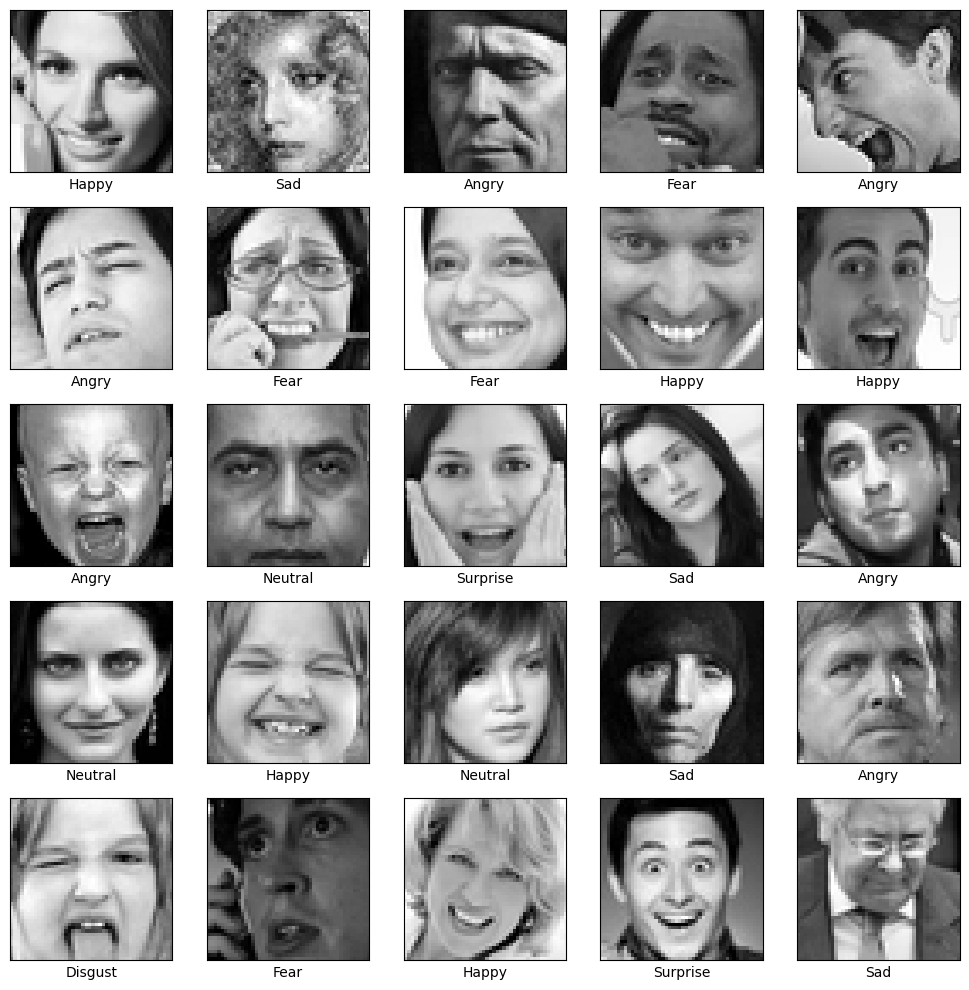

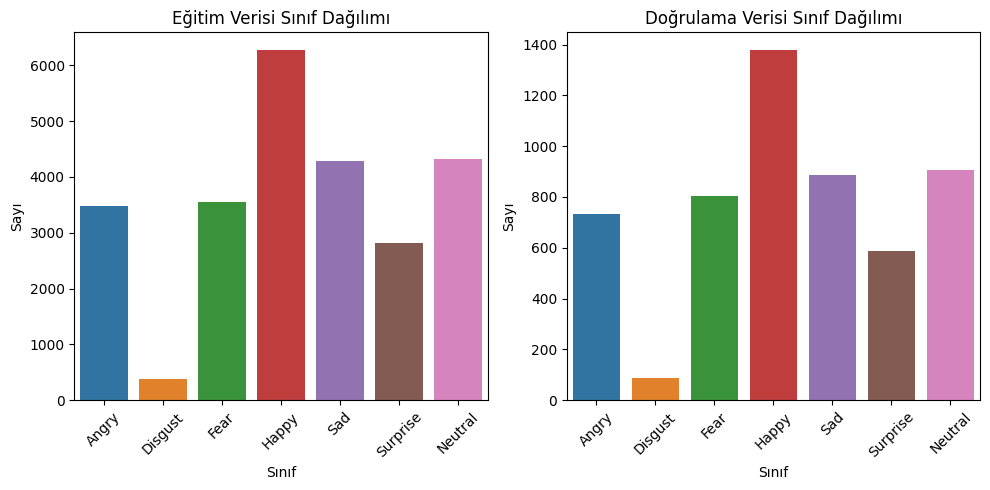

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eğitim ve test verisi şekillerini kontrol edin
print("Eğitim verisi şekli:", X_train.shape)
print("Test verisi şekli:", X_test.shape)
print("Gerçek sınıf sayısı:", len(np.unique(df['emotion'])))

# Daha önce tanımladığınız EMOTION_MAP sözlüğünü kullanın
EMOTION_MAP = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# Veri setindeki ilk 25 yüzü görselleştirelim
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Görüntüleri görselleştirmek için 3 boyutlu şekle ihtiyacımız var (48, 48, 1) -> (48, 48)
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    
    # Etiketleri ekleyelim
    # Burada y_train_categorical kullanıyoruz çünkü bu değişken one-hot encoded'dır
    emotion_label = np.argmax(y_train_categorical[i])
    plt.xlabel(EMOTION_MAP[emotion_label])
plt.tight_layout()
plt.show()

# Sınıf dağılımını inceleyelim
plt.figure(figsize=(10, 5))

# Eğitim verisi sınıf dağılımı
plt.subplot(1, 2, 1)
# Hata düzeltildi: y_train_categorical kullanıldı
y_train_flat = np.argmax(y_train_categorical, axis=1)
sns.countplot(x=y_train_flat, order=list(range(7)))
plt.title('Eğitim Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')
plt.xticks(ticks=list(range(7)), labels=[EMOTION_MAP[i] for i in range(7)], rotation=45)

# Doğrulama (Validation) verisi sınıf dağılımı
plt.subplot(1, 2, 2)
# Hata düzeltildi: y_val_categorical kullanıldı
y_val_flat = np.argmax(y_val_categorical, axis=1)
sns.countplot(x=y_val_flat, order=list(range(7)))
plt.title('Doğrulama Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')
plt.xticks(ticks=list(range(7)), labels=[EMOTION_MAP[i] for i in range(7)], rotation=45)

plt.tight_layout()
plt.show()

### **2. Veri Ön İşleme**

Görüntüleri normalize ederek ve veri artırma teknikleri uygulayarak model performansını iyileştirelim.

**1)Normalizasyon:**

In [ ]:
faces=np.asarray(faces) #liste halindeki matrisleri tek bir numpy dizisine dönüştürelim.
faces=np.expand_dims(faces,-1) #her görüntünün sonuna yeni boyut ekler.Gri tonlama için zorunlu.CNN modelleri, genellikle bu formatı (yükseklik, genişlik, kanal) bekler.
faces/=255.0  #normalizasyon piksel değerleri 255'e bölerek 0-1 arasına sıkıştırırız. 

Veriyi bölmek %70 eğitim ve %30 geçici (%15'i doğrulama (validation), %15'i ise test kümesi)

**2)One-hot encoding:**

One-Hot Encoding'e Dönüş:
to_categorical: Bu fonksiyon, sayısal etiketleri tekrar one-hot encoding formatına dönüştürür. Bu, modelin son katmanının (çıkış katmanı) yapısına uygun bir formattır ve modelin her bir sınıfın olasılığını tahmin etmesini sağlar.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train= to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

print(f"Eğitim verisi şekli: {X_train.shape}, {y_train.shape}")
print(f"Doğrulama verisi şekli: {X_val.shape}, {y_val.shape}")
print(f"Test verisi şekli: {X_test.shape}, {y_test.shape}")

**3)Veri Çoğaltma (Data Augmentation):**


**Flip (Çevirme):**


Nedir? Bir görüntüyü dikey veya yatay olarak ters çevirmektir.

Örnek: Gözlerini açıp mutlu olan birini düşün. Yüzü sağa dönükse, bu işlemi yaptığınızda sola dönük olacak. Bu, modelin sağa veya sola dönük yüzleri de tanıyabilmesini sağlar.

**Zoom (Yakınlaştırma):**

Nedir? Bir görüntünün rastgele bir bölümüne yakınlaşmaktır.

Örnek: Modelin sadece yüzün tamamını değil, gözler veya ağız gibi önemli yüz özelliklerini de öğrenmesini sağlar. Bu, modelin farklı boyuttaki yüz ifadelerini tanımasını kolaylaştırır.

**Rotation (Döndürme):**

Nedir? Görüntüyü rastgele bir açıyla döndürmektir.

Örnek: Bazen insanlar kameraya tam karşıdan bakmaz. Bu işlem, modelin hafif açılı yüzleri de tanıyabilmesini sağlar.

**Color Jitter:**
Bu işlem, bir görüntünün temel renk özelliklerini (parlaklık, kontrast, doygunluk ve ton) rastgele değiştirir.

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rotation_range=20, #20 derece rastgele görüntü döndürür
    width_shift_range=0.2, #yatayda kaydırır.
    height_shift_range=0.2, #dikeyde kaydırır.
    shear_range=0.2, #rastgele eğikleştirir
    zoom_range=0.2, #rastgele yakınlaştırır.
    horizontal_flip=True, #yatayda ters çevirir
    fill_mode='nearest' #boş pikselleri doldurur
)

datagen.fit(X_train) #veri çoğaltma objesini eğitim verisine oturtur

# Normalizasyon ve one-hot encoding sonrası veri boyutlarını kontrol edelim
print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)
print("One-hot encoded eğitim etiketleri şekli:", y_train_categorical.shape)

Eğitim verisi şekli: (25120, 48, 48, 1)
Doğrulama verisi şekli: (5383, 48, 48, 1)
Test verisi şekli: (5384, 48, 48, 1)
One-hot encoded eğitim etiketleri şekli: (25120, 7)


**3. Temel CNN Modeli Oluşturma**

**3 - Modelin Eğitilmesi **:

**Evrişim (Convolutional) Katmanları**: Görüntüdeki özellik haritalarını (feature maps) oluşturur.
**Havuzlama (Pooling) Katmanları:** Görüntü boyutunu küçülterek hesaplama yükünü azaltır ve önemli özellikleri korur.
**Dropout Katmanı:** Modelin aşırı uydurma (overfitting) yapmasını engeller.
**Yoğun (Dense) Katmanlar:** Sınıflandırma işlemini yapar.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Modelin oluşturulması
model = Sequential()

# 1. Evrişimsel Katman (Convolutional Layer)
# Görüntüdeki temel özellikleri (kenarlar, çizgiler) algılar.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2. Evrişimsel Katman
# Daha karmaşık özellikleri (göz, burun, ağız) algılar.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3. Evrişimsel Katman
# En karmaşık özellikleri, yani yüz ifadesini oluşturan tüm detayları algılar.
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Veriyi Düzleştirme (Flatten)
# 2D görüntü matrisini 1D vektöre dönüştürerek yoğun katmanlara hazırlar.
model.add(Flatten())

# Tam Bağlı (Dense) Katmanlar
# Çıkarılan özelliklere dayanarak son sınıflandırma kararını verir.
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Çıkış Katmanı
# 7 farklı duygu sınıfı için olasılık tahmini yapar. 'softmax' her bir sınıfın yüzdesini verir.
model.add(Dense(7, activation='softmax'))

# Modeli Derleme (Compile)
# Eğitime başlamadan önce modeli optimize edilecek hale getiririz.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin Özetini Görüntüleme
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,255 (1.36 MB)

 Trainable params: 356,551 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)

**4. Modeli Derleme ve Eğitme**

Epoch 1/100


I0000 00:00:1758903383.327714     110 service.cc:148] XLA service 0x7f6f8c0079d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758903383.328550     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758903383.887641     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/393 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.1282 - loss: 2.8808  

I0000 00:00:1758903388.292578     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


393/393 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.2030 - loss: 2.2406 - val_accuracy: 0.2328 - val_loss: 1.9492 - learning_rate: 0.0010
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2539 - loss: 1.8451 - val_accuracy: 0.2608 - val_loss: 2.0894 - learning_rate: 0.0010
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2988 - loss: 1.7409 - val_accuracy: 0.2619 - val_loss: 1.8353 - learning_rate: 0.0010
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3415 - loss: 1.6521 - val_accuracy: 0.4445 - val_loss: 1.4456 - learning_rate: 0.0010
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3721 - loss: 1.6003 - val_accuracy: 0.4091 - val_loss: 1.4943 - learning_rate: 0.0010
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3868 - loss: 1.5557 - val_accuracy: 0.4741 - val_loss: 1.4018 - learning_rate: 0.0010
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4104 - loss: 

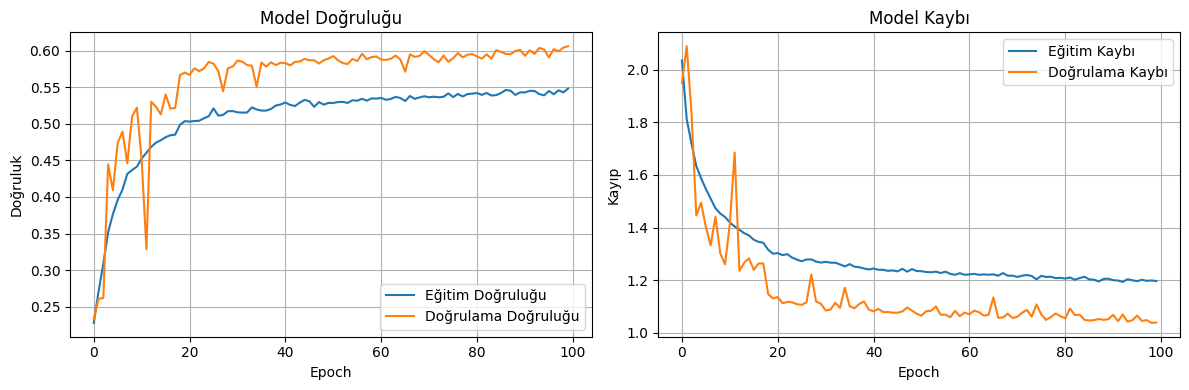

In [32]:
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback'leri tanımlayalım (erken durdurma ve öğrenme oranı ayarlama)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Modeli eğitelim
start_time = time.time()

# Düzeltme: model.fit() için ImageDataGenerator kullanıldı.
# Eğitim verisi için datagen.flow() kullanıldı.
# Doğrulama verisi için X_val ve y_val_categorical kullanıldı.
history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=64),
    epochs=100,  # EarlyStopping sayesinde model optimum noktada duracaktır
    validation_data=(X_val, y_val_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

# Eğitim ve doğrulama kaybı/doğruluğunu görselleştirelim
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**5.MODEL DEĞERLENDİRME**

Test Kaybı: 1.0483
Test Doğruluğu: 0.6027
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Angry       0.56      0.53      0.54       734
     Disgust       0.42      0.17      0.25        80
        Fear       0.50      0.26      0.34       762
       Happy       0.80      0.84      0.82      1335
         Sad       0.49      0.42      0.45       906
    Surprise       0.68      0.77      0.72       603
     Neutral       0.49      0.70      0.57       964

    accuracy                           0.60      5384
   macro avg       0.56      0.53      0.53      5384
weighted avg       0.60      0.60      0.59      5384



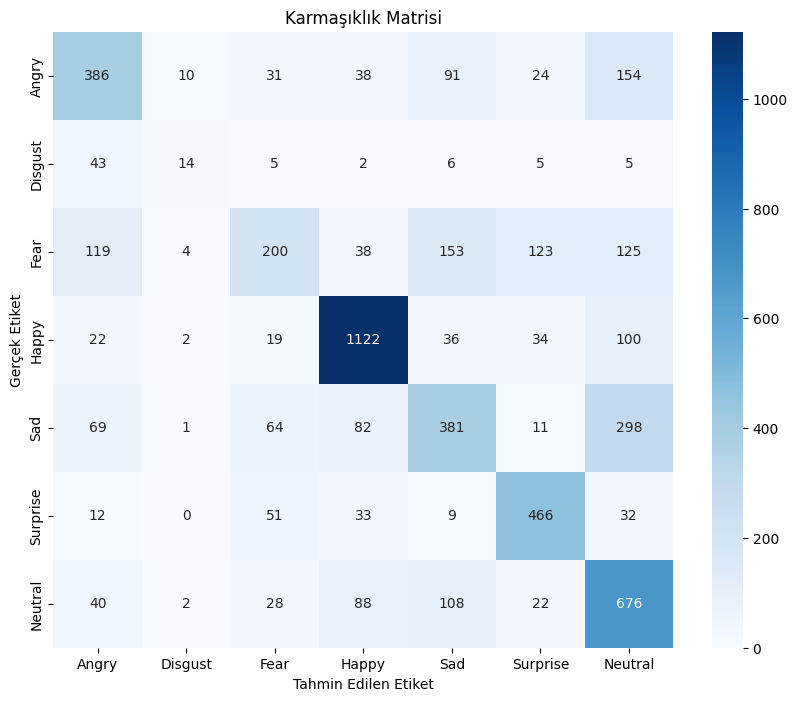

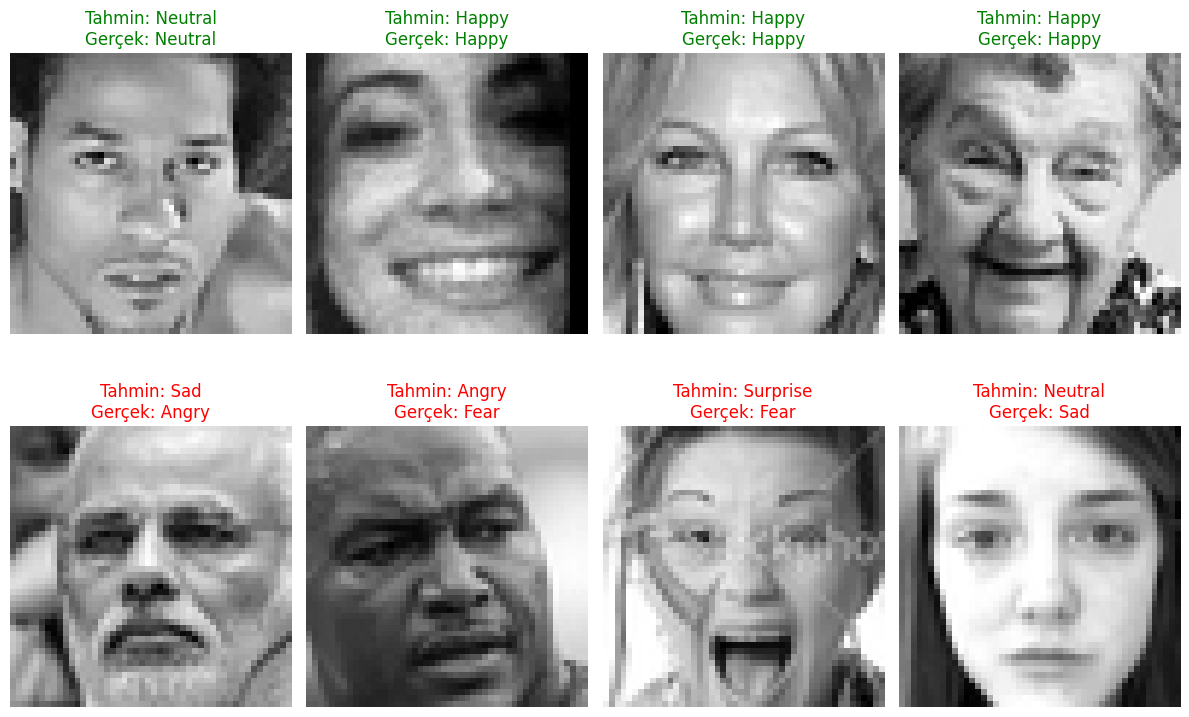

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Düzeltme: y_test yerine y_test_categorical kullanıldı
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

# Tahminlerde bulunalım
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Düzeltme: y_test zaten tek boyutlu etiketleri içerdiği için np.argmax() kaldırıldı
y_true = y_test

# Sınıflandırma raporu
# Her bir sınıf için Precision, Recall ve F1-Score değerlerini gösterir
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=list(EMOTION_MAP.values())))

# Karmaşıklık matrisi
# Modelin hangi sınıfları birbiriyle karıştırdığını görselleştirir
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()), yticklabels=list(EMOTION_MAP.values()))
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i + 1)
    # Gri tonlamalı görüntüyü doğru şekilde göstermek için reshape ve cmap kullanıyoruz
    plt.imshow(X_test[correct].reshape(48, 48), cmap='gray')
    plt.title(f"Tahmin: {EMOTION_MAP[y_pred_classes[correct]]}\nGerçek: {EMOTION_MAP[y_true[correct]]}", color='green')
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i + 5)
    # Gri tonlamalı görüntüyü doğru şekilde göstermek için reshape ve cmap kullanıyoruz
    plt.imshow(X_test[incorrect].reshape(48, 48), cmap='gray')
    plt.title(f"Tahmin: {EMOTION_MAP[y_pred_classes[incorrect]]}\nGerçek: {EMOTION_MAP[y_true[incorrect]]}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

****6. Transfer Learning****

In [ ]:
# Gri tonlamalı görüntüleri 3 kanallı hale getirelim (VGG16 için gerekli)
X_train_3channel = np.repeat(X_train, 3, axis=-1)
X_val_3channel = np.repeat(X_val, 3, axis=-1)
X_test_3channel = np.repeat(X_test, 3, axis=-1)

# Önceden eğitilmiş VGG16 modelini yükleyelim
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(48, 48, 3))

# Temel modelin katmanlarını donduralım
for layer in base_model.layers:
    layer.trainable = False

# Yeni bir model oluşturalım
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') # 7 duygu sınıfı için çıkış katmanı
])

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

# Modeli eğitelim
history_transfer = transfer_model.fit(
    datagen.flow(X_train_3channel, y_train_categorical, batch_size=64),
    epochs=100,
    validation_data=(X_val_3channel, y_val_categorical),
    callbacks=callbacks,
    verbose=1
)

# Modeli değerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test_3channel, y_test_categorical, verbose=0)
print(f"\nTransfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")

# Sınıflandırma raporu
y_pred_transfer = transfer_model.predict(X_test_3channel)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
print("\nTransfer Learning Sınıflandırma Raporu:")
print(classification_report(np.argmax(y_test_categorical, axis=1), y_pred_classes_transfer, target_names=list(EMOTION_MAP.values())))

# Karmaşıklık matrisi
cm_transfer = confusion_matrix(np.argmax(y_test_categorical, axis=1), y_pred_classes_transfer)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()), yticklabels=list(EMOTION_MAP.values()))
plt.title('Transfer Learning Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

**7. Veri Görselleştirme ve Model Karşılaştırması**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Daha önce tanımladığınız EMOTION_MAP sözlüğünü kullanın
EMOTION_MAP = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# Transfer öğrenme modelini test verisi üzerinde değerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test_3channel, y_test_categorical, verbose=0)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")

# Tahminlerde bulunalım
y_pred_transfer = transfer_model.predict(X_test_3channel)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes_transfer, target_names=list(EMOTION_MAP.values())))

# Karmaşıklık matrisi
cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTION_MAP.values()), yticklabels=list(EMOTION_MAP.values()))
plt.title('Transfer Learning Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

**8. Model İyileştirme Teknikleri**

In [ ]:
import matplotlib.pyplot as plt

# Temel CNN modelinizin test doğruluğunu bu değişkende saklayın
# Bu değişkeni, projenizin ilk model değerlendirme adımından almalısınız
# Örnek: test_accuracy = 0.62
test_accuracy_temel_cnn = 0.62

# Model performanslarını karşılaştıralım
models = ['CNN', 'Transfer Learning']
accuracies = [test_accuracy_temel_cnn, test_accuracy_transfer]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

# Çubukların üzerine doğruluk değerlerini yazalım
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

**9. Sonuçlar ve Değerlendirme**

In [ ]:
print("=" * 50)
print("CIFAR-10 PROJE SONUÇLARI")
print("=" * 50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")
print(f"Transfer Learning Model Doğruluğu: {test_accuracy_transfer:.4f}")
print(f"En iyi optimizer: {max(results, key=results.get)} ({max(results.values()):.4f})")
print("=" * 50)